# Mesure de l'incertitude d'un modèle de régression
---

Dans ce TP, nous allons estimer des intervalles de prédiction à partir de la distribution de résidus estimés par différentes méthodes :

- Directement à partir des données d'entraînement
- Sur un jeu de calibration
- Par validation croisée
- En utilisant MAPIE

Nous allons appliquer ces méthodes sur un jeu de données uni-dimensionnel généré à partir d'une fonction analytique et d'un bruit gaussien. Nous allons ainsi pouvoir déterminer la validité de nos intervalles de prédiction via deux métriques : 

- la couverture "effective", qui est le pourcentage de données de test dont les vraies valeurs sont inclues dans les intervalles de prédiction. Par exemple, pour un niveau de confiance cible de 90%, il faut que 90% de mes données de test soit comprises dans les barres d'erreur.
- la largeur moyenne des intervalles de prédiction qui doit être la plus proche possible de la largeur "théorique" ayant servie à générer le bruit de données

> **NB** : le type d'incertitude abordée dans ce TP est `l'incertitude résiduelle`, i.e. provenant des bruits dans nos données

# Import

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from mapie.regression import MapieRegressor
import copy
import sys
sys.path.append("../src")
from plot_utils import plot_1d_data

> **NB** : Utiliser la graine aléatoire suivante parmi où cela est nécessaire pour assurer la réproducibilité des résultats

In [ ]:
RANDOM_SEED = 72

## 1. Construction du jeu de données et du modèle de base

### Construction d'un jeu de données artificiel

Commençons ici par construire un jeu de données artificiel. Nous utiliserons la fonction analytique $f(x) = x \times sin(x)$ à laquelle nous ajoutons un bruit gaussien dont l'amplitude peut être définie en entrée. Les données d'entraînement et de test sont obtenues par une distribution uniforme entre deux valeurs minimale et maximale.

In [ ]:
def x_sinx(x):
    """One-dimensional x*sin(x) function."""
    return x*np.sin(x)

La fonction générera des données synthétiques d'entrainement et de test de la façon suivante :

* générer un array `X_train` de `n_samples` nombres, dans l'intervalle `min_x` - `max_x` (voir la fonction `np.linspace`). Ensuite mélanger aléatoirement `X_train`
* générer un autre array `X_test` de `n_samples*5` nombres dans l'intervalle `min_x` - `max_x`
* générer des labels `y_train` et `y_test`, résultat de l'application de la fonction `x_sinx` sur `X_train` et `X_test`
* créer une copie de `y_test` dans une nouvelle  variable `y_test_true` (qui représente les labels de test avant perturbation)
* ajouter un bruit gaussien de variance `sigma` à `y_train` et à `y_test`
* ajouter une dimension supplémentaire à `X_train` et `X_test` pour qu'ils soient de dimensions (`n_samples`, 1) et (`n_samples*5`, 1) respectivement
* finalement retourner `X_train`, `y_train`, `X_test`, `y_test`, `y_test_true`

In [ ]:
def get_1d_data_with_constant_noise(f, min_x, max_x, n_samples, sigma):
    """
    Generate 1D noisy data uniformely from the given function
    and standard deviation for the noise.
    """
    
    np.random.seed(RANDOM_SEED)
    # get train and test input data
    X_train = np.linspace(min_x, max_x, n_samples)
    np.random.shuffle(X_train)
    X_test = np.linspace(min_x, max_x, n_samples*5)
    # Get train and test labels
    y_train = f(X_train)
    y_test = f(X_test)
    y_test_true = copy.deepcopy(y_test)
    # Add Gaussian noise to the label
    y_train += np.random.normal(0, sigma, len(y_train))
    y_test += np.random.normal(0, sigma, len(y_test))
    
    # Ajout de dimension supplémentaire
    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    
    return X_train, y_train, X_test, y_test, y_test_true

In [ ]:
min_x, max_x, n_samples, sigma = -5, 5, 100, 0.5
X_train, y_train, X_test, y_test, y_mesh = get_1d_data_with_constant_noise(
    x_sinx, min_x, max_x, n_samples, sigma
)

In [ ]:
plt.xlabel("x") ; plt.ylabel("y")
plt.scatter(X_train, y_train, color="C0")
_ = plt.plot(X_test, y_mesh, color="C1")

### Définition du modèle de base

Nous considérons ici un modèle de régression [Random Forest](https://en.wikipedia.org/wiki/Random_forest) avec les valeurs par défaut de ``sklearn``.

In [ ]:
rf_model = RandomForestRegressor(random_state=RANDOM_SEED)

## 2. Approche 1 : Intervalles de prédiction par la méthode naive

Commençons ici par une méthode dite "naive"; les intervalles de prédiction sont définis directement à partir des résidus sur les données d'entraînement. 

---
**Exercice 1**

* Entrainer le modèle random forest sur le jeu d'entrainement
* Utiliser le modèle entrainé pour prédire sur le jeu de données `X_train`
* Calculer les résidus (erreurs) absolus de prédiction $|y\_train - y\_train\_pred|$ 
* estimer le quantile associé à la distribution des résidus et un niveau de confiance défini à 95\% (ou autrement dit à niveau de risque ``alpha`` de 5\%), ce quantile servira de largeur pour la construction des intervalles de prédiction pour les nouvelles données de test (c.f. `np.quantile`)

In [8]:
# TODO
mdl = rf_model
mdl.fit(X_train, y_train)
y_train_preds = mdl.predict(X_train)

In [9]:
# TODO
residuals = np.abs(y_train - y_train_preds)

In [ ]:
# TODO
alpha = 0.05
quantile = np.quantile(residuals, 1 - alpha, interpolation="higher")

---
**Exercice 2** 

* Construisons maintenant les prédictions `y_test_preds` de taille (n_test, )
* Calculer la borne supérieure `y_test_pred_upper` de l'intervalle de prédiction en ajoutant le quantile des résidus aux prédictions `y_test_preds`
* Calculer la borne inferieure `y_test_pred_lower` de l'intervalle de prédiction en soustrayant le quantile des résidus aux prédictions `y_test_preds`

In [ ]:
# TODO
y_test_preds = mdl.predict(X_test)
y_test_pred_upper = y_test_preds + quantile
y_test_pred_lower = y_test_preds - quantile

Visualisons les intervalles de prédictions estimés :

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
plot_1d_data(
    X_train.ravel(),
    y_train.ravel(),
    X_test.ravel(),
    y_mesh.ravel(),
    1.96*sigma,
    y_test_preds.ravel(),
    y_test_pred_lower,
    y_test_pred_upper,
    ax=axs,
    title="Méthode Naive"
)

----
**Exercice 3**

* Commenter les intervalles estimés par cette méthode par rapport aux intervalles théoriques d'après le graphique ci-dessus
* Calculer la couverture `coverage` et la largeur `width` de l'intervalle de la méthode naive :
    * la couverture est définie comme la des labels de test qui sont compris dans les intervalles estimés
    * la largeur est la moyenne des écarts entre les bornes supérieures et inferieures des intervalles
* Comparer ces valeurs avec les valeurs théoriques qui sont de 95% et 1.96 respectivement

In [13]:
# TODO
coverage = ((y_test > y_test_pred_lower) & (y_test < y_test_pred_upper)).mean().round(3)
width = (y_test_pred_upper - y_test_pred_lower).mean().round(2)

In [14]:
coverages_widths = pd.DataFrame(index=["Naive"], columns=["Coverage", "Width"])
coverages_widths.loc["Naive", "Coverage"] = coverage
coverages_widths.loc["Naive", "Width"] = width

In [15]:
coverages_widths

,Coverage,Width
Naive,0.498,0.77


***TODO***
> Il semble que les intervalles de prédiction estimés avec cette première méthodes sont beaucoup plus étroits que les intervalles de confiance "théoriques" que nous cherchions à reproduire.

> La couverture effective n'est seulement que de $\sim 0.5$ ! Seulement la moitié des données de test sont compris dans les intervalles de prédiction de cette première méthode alors que nous cherchons à avoir un niveau de confiance de 95 \%. Cette faible couverture est due aux intervalles étroits, leur largeur n'étant que de 0.77 alors que la largeur théorique est de 1.96.

> Ce résultat n'est pas surprenant, nous avons estimer les résidus directement à partir des données d'entraînement qui ont été utilisés pour optimiser le modèle. Un modèle comme le Random Forest a tendance à sur-apprendre (ou overfitter), et produit donc des résidus beaucoup trop faibles et donc des intervalles de prédiction beaucoup trop optimistes.

## 3. Approche 2 : Intervalles de prédiction par séparation en jeux d'entraînement et de calibration

Pour résoudre le problème de surapprentissage survenu lors de la première méthode, il est nécessaire de créer un jeu de calibration afin de calibrer les résidus sur des données qui n'auront pas été vues lors de l'entraînement du modèle.


---
**Exercice 4**

Pour construire les intervalles de prédiction avec cette nouvelle méthode, il faut donc :

- créer deux jeux d'entraînement (``X_train_train`` et ``y_train_train``) et de calibration (``X_train_calib`` et ``y_train_calib``) à partir des données d'entraînement  (``X_train`` et ``y_train``). Les données de calibrations représenterons 25% des données de l'entrainement 
- entraîner le modèle de base ``mdl`` sur les données d'entraînement ``X_train_train`` et ``y_train_train``
- estimer les résidus ``residuals`` sur les données de calibration(``X_train_calib`` et ``y_train_calib``)
- estimer le quantile associé à la distribution des résidus et un niveau de confiance défini à 95\%, ce quantile servira de largeur pour la construction des intervalles de prédiction pour les nouvelles données de test
- Prédire le jeu de test `y_test_preds` puis calculer les bornes supérieures et inférieures des intervalles de prédictions

In [16]:
# TODO

X_train_train, X_train_calib, y_train_train, y_train_calib = train_test_split(
    X_train, y_train, test_size=0.25, shuffle=True, random_state=RANDOM_SEED
)

In [17]:
# TODO
mdl = rf_model
mdl.fit(X_train_train, y_train_train)
y_train_preds = mdl.predict(X_train_calib)
residuals = np.abs(y_train_calib - y_train_preds)

In [18]:
alpha = 0.05
quantile = np.quantile(residuals, 1 - alpha, interpolation="higher")

In [19]:
# TODO
y_test_preds = mdl.predict(X_test)
y_test_pred_upper = y_test_preds + quantile
y_test_pred_lower = y_test_preds - quantile

Comparons maintenant les intervalles de prédiction estimés par cette méthode "Train/calibration split" avec les "vraies" intervalles de confiance associés au bruit gaussien de nos données.

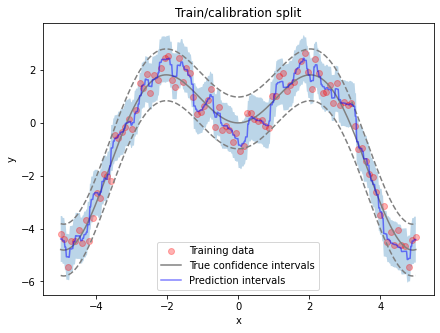

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
plot_1d_data(
    X_train.ravel(),
    y_train.ravel(),
    X_test.ravel(),
    y_mesh.ravel(),
    1.96*sigma,
    y_test_preds.ravel(),
    y_test_pred_lower,
    y_test_pred_upper,
    ax=axs,
    title="Train/calibration split"
)

---
**Exercice 5**

* Commenter la visualisation des nouveaux intervalles par rapport à ceux de la méthode naive
* Calculer à nouveau la couverture `coverage` et la largeur `width` 
* Comparer avec les valeurs théoriques et la méthode naive

In [21]:
# TODO
coverage = ((y_test > y_test_pred_lower) & (y_test < y_test_pred_upper)).mean().round(3)
width = (y_test_pred_upper - y_test_pred_lower).mean().round(2)

In [22]:
coverages_widths.loc["Train/calib split", "Coverage"] = coverage
coverages_widths.loc["Train/calib split", "Width"] = width

In [23]:
coverages_widths

,Coverage,Width
Naive,0.498,0.77
Train/calib split,0.854,1.74


***TODO***

> Cette nouvelle méthode semble produire des intervalles de prédiction beaucoup plus larges que la méthode "naive" ! Pour vérifier quantitativement cette impression visuelle, calculs la couverture effective et la largeur moyenne des intervalles de prédiction.

> La couverture effective a augmenté sensiblement, passant de 0.48 à 0.85 ! L'estimation des résidus sur un jeu de calibration jamais vu par le modèle lors de l'entraînement a permis d'obtenir des intervalles de prédiction plus robustes et "généralisables". Cependant, les intervalles de prédiction sont encore un peu trop étroits, induisant une couverture encore insuffisante. De plus, nous avons du "sacrifier" une partie de nos données pour les mettre de coté.

## 4. Intervalles de prédiction par validation croisée

Afin de pouvoir utiliser l'intégralité des données d'entraînement pour l'entraînement *et* la calibration du modèle, nous allons maintenant adopter une stratégie de validation croisée. Pour ce faire, nous allons séparer nos données d'entraînement en $K$ plis, le modèle de base sera ainsi entraîné $K$ fois, chacun sur $K-1$ plis le dernier pli servira ensuite de jeu de calibration.


---
**Exercice 6**

Pour construire les intervalles de prédiction avec cette nouvelle méthode, il faut donc :

- Utiliser `KFold` de `sklearn` afin séparer le jeu d'entraînement en 5 plis (i.e. k = 5)
- via une boucle `for`:
    * entraîner le modèle de base ``mdl`` sur chaque jeu d'entraînement généré par `KFold`
    * sauvegarder les prédictions de chaque donnée du plis de calibration
- estimer les résidus ``residuals`` sur l'ensemble du jeu d'entraînement
- estimer le quantile 95% associé à la distribution des résidus
- Entrainer un modèle sur l'ensemble des données d'entrainement `X_train` et l'utiliser pour prédire le jeu de test `y_test_preds`
- calculer les bornes supérieures et inférieures des intervalles de prédictions pour les prédicitions du jeu de test `y_test_preds`

In [24]:
# TODO

mdl = rf_model
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
y_train_preds = np.empty_like(y_train)

for train_index, calib_index in kf.split(X_train):
    mdl_ = mdl.fit(X_train[train_index], y_train[train_index])
    y_train_preds[calib_index] = mdl_.predict(X_train[calib_index])

residuals = np.abs(y_train - y_train_preds)

In [25]:
# TODO
alpha = 0.05
quantile = np.quantile(residuals, 1 - alpha, interpolation="higher")

In [26]:
# TODO
mdl.fit(X_train, y_train)
y_test_preds = mdl.predict(X_test)
y_test_pred_upper = y_test_preds + quantile
y_test_pred_lower = y_test_preds - quantile

Comparons maintenant les intervalles de prédiction estimés par cette méthode "Cross-validation" avec les "vraies" intervalles de confiance associés au bruit gaussien de nos données.

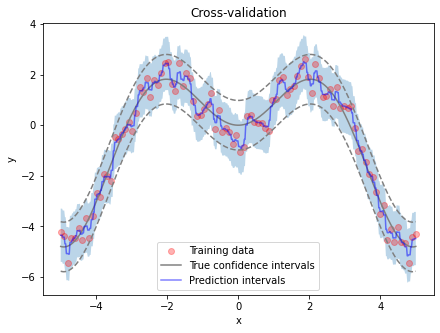

In [27]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
plot_1d_data(
    X_train.ravel(),
    y_train.ravel(),
    X_test.ravel(),
    y_mesh.ravel(),
    1.96*sigma,
    y_test_preds.ravel(),
    y_test_pred_lower,
    y_test_pred_upper,
    ax=axs,
    title="Cross-validation"
)

---
**Exercice 7**

* Commenter la visualisation des nouveaux intervalles par rapport à ceux des méthodes précédentes
* Calculer à nouveau la couverture `coverage` et la largeur `width` 
* Comparer avec les valeurs théoriques et les méthdes précédentes

In [28]:
# TODO

coverage = ((y_test > y_test_pred_lower) & (y_test < y_test_pred_upper)).mean().round(3)
width = (y_test_pred_upper - y_test_pred_lower).mean().round(2)

In [29]:
coverages_widths.loc["Cross-validation", "Coverage"] = coverage
coverages_widths.loc["Cross-validation", "Width"] = width

In [30]:
coverages_widths

,Coverage,Width
Naive,0.498,0.77
Train/calib split,0.854,1.74
Cross-validation,0.918,2.11


***TODO***

> Nous obtenons à présent une couverture effective 92% qui se rapproche bien de la couverture "cible" de 95 \% ! Félicitations ! Grâce à la stratégie de validation croisée, nous avons ainsi utilisé l'intégralité des données d'entraînement pour estimer les résidus et les intervalles de prédiction.

## 5. Estimation d'intervalles de prédiction avec MAPIE

Bien que très simple à mettre en place et intuitive, la stratégie de validation croisée est au coeur des méthodes de prédiction conforme développées notamment depuis une vingtaine d'années dans la communauté scientifique. Il s'agit tout simplement de calibrer des *scores*, ici les résidus, sur des données qui n'ont pas été vues par le modèle durant son entraînement. 

Deux inconvénients demeurent néanmoins dans la méthode implémentée précédemment : 
- les intervalles de prédiction ainsi construits restent constants avec $X$ et ne permettent pas de capturer une augmentation de l'incertitude sur de nouveaux domaines de valeurs jamais vus par le modèle durant son entraînement.
-  des instabilités peuvent survenir dans certains cas de haute dimensionalité (ou sur des faibles tailles de jeux de données)

Nous avons ainsi développé à Quantmetry un package dénommé MAPIE (pour Model Agnostic Prediction Interval Estimator) afin d'estimer des intervalles de prédiction grâce à l'implémentation de méthodes de prédiction conforme à l'état de l'art, et nous permettant de résoudre les deux problèmes mentionnés plus haut.

Nous allons utiliser la méthode `CV+` de MAPIE, qui est une variante de la validation croisée implémentée précédemment.

---
**Exercice 8**

Le dernier exercice consiste maintenant à utiliser MAPIE pour estimer des intervalles de prédiction grâce à la méthode CV+. Pour ce faire, nous vous invitons à regarder la documentation disponible [ici](https://mapie.readthedocs.io/en/latest/), notamment les tutoriels ainsi que la [description théorique pour la régression](https://mapie.readthedocs.io/en/latest/theoretical_description_regression.html). 

In [31]:
# TODO

mdl = rf_model
mapie = MapieRegressor(estimator=mdl, method="plus", cv=KFold(5, shuffle=True, random_state=RANDOM_SEED))
mapie.fit(X_train, y_train)

MapieRegressor(cv=KFold(n_splits=5, random_state=72, shuffle=True),
               estimator=RandomForestRegressor(random_state=72))

In [32]:
alpha = 0.05
y_test_preds, y_test_pis = mapie.predict(X_test, alpha=alpha)

y_test_pred_lower = y_test_pis[:, 0, 0]
y_test_pred_upper = y_test_pis[:, 1, 0]

Comparons maintenant les intervalles de prédiction estimés par cette méthode "Cross-validation" avec les "vraies" intervalles de confiance associés au bruit gaussien de nos données.

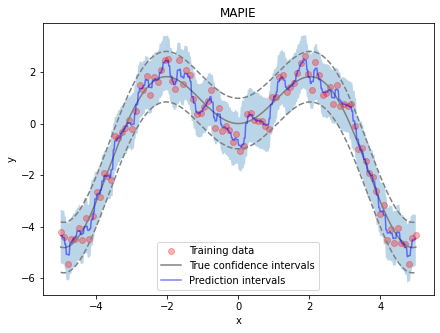

In [33]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
plot_1d_data(
    X_train.ravel(),
    y_train.ravel(),
    X_test.ravel(),
    y_mesh.ravel(),
    1.96*sigma,
    y_test_preds.ravel(),
    y_test_pred_lower,
    y_test_pred_upper,
    ax=axs,
    title="MAPIE"
)

In [34]:
# TODO
coverage = ((y_test > y_test_pred_lower) & (y_test < y_test_pred_upper)).mean().round(3)
width = (y_test_pred_upper - y_test_pred_lower).mean().round(2)

In [35]:
coverages_widths.loc["MAPIE", "Coverage"] = coverage
coverages_widths.loc["MAPIE", "Width"] = width

In [36]:
coverages_widths

,Coverage,Width
Naive,0.498,0.77
Train/calib split,0.854,1.74
Cross-validation,0.918,2.11
MAPIE,0.936,2.13


> La méthode CV+ nous permet de nous rapprocher encore plus de la couverture cible avec une couverture effective de 0.94. En outre, la largeur de l'intervalle de prédiction et similaire à celui fourni par la méthode de validation croisée simple.

> La librairie MAPIE implémente plusieurs autres méthodes à l'état de l'art, n'hésitez pas à jeter un coup d'oeil à la documentation ainsi qu'aux tutoriels